# Notebook contains  all sites emissivity sensitivity and bias in local and MODIS LST :

In [1]:
from __future__ import division
from IPython.display import display
from sympy import diff, init_printing
init_printing() 
init_printing(use_latex='mathjax')
from sympy import diff, Eq, exp, init_printing, log, solve, sqrt
init_printing() 
from sympy.printing import StrPrinter
StrPrinter._print_Quantity = lambda self, expr: str(expr.abbrev)
# displays short units (m instead of meter)
from matplotlib.cbook import flatten

In [2]:
# Using environmental science for symbolic math, see https://github.com/environmentalscience/essm
from essm.variables._core import BaseVariable, Variable
from essm.equations import Equation
from essm.equations.physics.thermodynamics import *
from essm.variables.units import derive_unit, SI, Quantity
from essm.variables.utils import replace_defaults, replace_variables
from sympy.physics.units import joule, kelvin,gram,kilogram,meter, mole, pascal, second
from essm.variables.utils import generate_metadata_table
from matplotlib import rc 
import matplotlib
import math
import sympy
from essm.variables.units import derive_unit, derive_baseunit, markdown, SI
from essm.variables.units import joule, kelvin, kilogram, meter, pascal, second, watt

from sympy import diff, Eq, exp, init_printing, log, solve, sqrt
import re


In [3]:
import numpy as np
from netCDF4 import Dataset
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import sys
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



In [4]:
import glob
from netCDF4 import Dataset
import os
from sympy.printing.theanocode import theano_function

## Plot Path :

In [5]:
plt_path= '/home/thakur_21505/lst-retrival-from-fluxnet-data/latex/final_plots/'

## Brookings

In [6]:
filename = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/leonardo_conference/US_Brook/AMF_US-Bkg_BASE_HH_4-1.csv'
brookframe = pd.read_csv(filename, error_bad_lines=False,  na_values=-9999, skiprows= 2)
           

In [7]:
brookframerang = pd.date_range('1/1/2004 00:00', periods=len(brookframe.index), freq='30min')
brookframe.index = brookframerang
brookframe=brookframe.replace(-9999.000000, np.nan)
brookframe["T_a"] = pd.Series(brookframe.TA + 273.15, index=brookframe.index)
#brookframe

## Yatir forest:

In [8]:
filename = '/home/thakur_21505/yatir_fluxnet/808983895/EFDC_L2_Flx_ILYat_2005_v03_30m.txt'

yatframe = pd.read_csv(filename, error_bad_lines=False,  na_values=-9999)
                      


In [9]:
yatframerang = pd.date_range('1/1/2005 00:00', periods=len(yatframe.index), freq='30min')
yatframe.index = yatframerang
yatframe=yatframe.replace(-9999.000000, np.nan)
yatframe["T_a"] = pd.Series(yatframe.TA + 273.15, index=yatframe.index)

## Alice Spring:

In [10]:
AS = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/leonardo_conference/data/AS/' 
ASncfile = xr.open_mfdataset(AS +'/*.nc')#, combine='by_coords')#, combine='nested')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will 

### dataframe

In [11]:
asframe= ASncfile.to_dataframe()
asframe.index=asframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
asframe.reset_index(inplace=True)
asframe.index=asframe.time 
asframe=asframe[(asframe.Fld_QCFlag==00)&(asframe.Flu_QCFlag==00)]#&(asframe.Ws_QCFlag==00)&(asframe.Fh_QCFlag==00)&(asframe.Ta_QCFlag==00)]
asframe=asframe.replace(-9999.000000, np.nan)
asframe["T_a"] = pd.Series(asframe.Ta + 273.15, index=asframe.index)
#asframe

In [12]:
df=asframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_as= df_inter.interpolate()

In [13]:
mod_as ='/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/leonardo_conference/data/modis_txt/alispr_moddata.csv'

modis_as = pd.read_csv(mod_as)#engine='python',header=None)
modis_as1=pd.DataFrame(modis_as)
modis_as1.index=modis_as1.timestamp
###
df_mod=pd.to_datetime(modis_as1.index)### converting timestamp to 
#####
Dfec_mod=Df_as.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_as1.LST
Dfec_mod_as=Dfec_mod.copy()
#Dfec_mod_as=Dfec_mod_as.sort_index()

In [14]:
Dfec_mod_as

,Fh,Fld,Flu,Ta,Ws,Fn,modistemp
timestamp,,,,,,,
2016-01-02 10:12:00,370.874111,347.859320,481.288100,24.748250,6.686248,620.754240,314.72
2016-01-03 10:54:00,280.144572,371.090407,531.944660,30.552513,3.340745,686.277280,316.26
2016-01-04 10:00:00,134.499177,374.851467,519.434167,30.685487,2.061898,552.909367,319.96
2016-01-05 10:42:00,159.755460,394.875960,540.564293,31.992715,2.150245,663.147980,319.48
2016-01-06 09:48:00,231.939672,359.727420,503.410613,28.767004,3.971116,511.779360,315.66
...,...,...,...,...,...,...,...
2016-12-19 10:12:00,236.321644,422.688600,524.066440,33.214224,2.654191,415.263280,313.92
2017-01-02 10:24:00,250.101373,386.185553,469.615340,28.336532,6.309860,683.782860,304.74
2017-01-04 10:12:00,212.140427,403.228040,501.443380,31.682340,4.456403,605.547220,314.64


## Howard Spring

In [15]:
HS = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/leonardo_conference/data/HS/' 
HSncfile = xr.open_mfdataset(HS +'/*.nc',combine='by_coords')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [16]:
#HSncfile.info()

In [17]:
hsframe= HSncfile.to_dataframe()
hsframe.index=hsframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
hsframe.reset_index(inplace=True)
hsframe.index=hsframe.time 
hsframe=hsframe[(hsframe.Fld_QCFlag==00)&(hsframe.Flu_QCFlag==00)]#&(hsframe.Fn_QCFlag==00)&(hsframe.Ws_QCFlag==00)]
hsframe=hsframe.replace(-9999.000000, np.nan)
hsframe["T_a"] = pd.Series(hsframe.Ta + 273.15, index=hsframe.index)




/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [18]:
df=hsframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_hs= df_inter.interpolate()

In [19]:
### modis how

In [20]:
mod_hs = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/Howspr_Lstdata.csv'
modis_hs = pd.read_csv(mod_hs)#engine='python',header=None)
modis_hs1=pd.DataFrame(modis_hs)
modis_hs1.index=modis_hs1.timestamp
###
df_mod=pd.to_datetime(modis_hs1.index)### converting timestamp to 
#####
Dfec_mod=Df_hs.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_hs1.LST
Dfec_mod_hs=Dfec_mod.copy()
Dfec_mod_hs=Dfec_mod_hs.sort_index()

In [21]:
Dfec_mod_hs

,Fh,Fld,Flu,Ta,Ws,Fn,modistemp
timestamp,,,,,,,
2016-01-17 09:48:00,75.518052,397.73272,449.650520,31.420244,1.167157,537.091546,299.62
2016-02-29 11:00:00,220.970773,412.79490,461.331400,31.659610,1.389172,754.687400,305.68
2016-03-18 09:48:00,86.246580,410.19076,445.713900,28.979268,1.985802,395.108484,304.06
2016-03-28 10:30:00,127.389958,395.48820,452.266400,30.242530,0.788409,592.967280,300.84
2016-04-03 10:24:00,78.562131,385.68514,450.871260,29.377058,1.773533,570.998640,301.12
...,...,...,...,...,...,...,...
2018-10-24 10:48:00,194.913463,399.02328,482.370540,32.197897,1.503024,668.595516,310.28
2018-10-27 10:00:00,115.147886,394.81250,452.778300,29.351868,0.632068,500.511680,311.78
2018-11-10 11:00:00,125.707242,413.23410,469.274300,31.626786,1.625182,612.867080,310.52


## wind speed

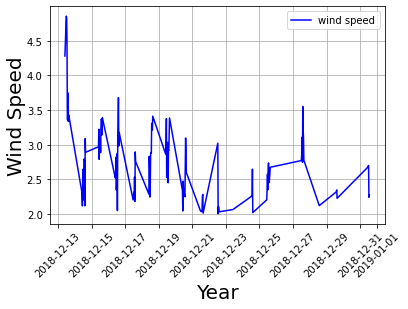

In [22]:
year=2018
month=12
hourmax=15
hourmin=10
df_all=hsframe.copy()

df =df_all[(df_all.index.year == year) & (df_all.index.month == month)& (df_all.index.hour >= hourmin)
           & (df_all.index.hour <= hourmax) &(df_all.Fn > 25) & (df_all.Ws > 2) ]
plt.plot(df.index,df.Ws,color= 'blue')
#plt.plot(df.index,df.Fld, ".",color= 'orange')
plt.xticks(rotation=45)
plt.xlabel('Year', ha='center',fontsize=20)
plt.ylabel('Wind Speed', labelpad=10, va='center',fontsize=20)
plt.legend(['wind speed'])
#plottitle ='{0},{1},{2},Diurnal wind speed at Hsframe'.format(str(year),
                                                             #str(month))
                                                              #df.index[0].date().strftime
#fname = 'wind speed at Hsframe'.format(df.index[0].date().strftime('%Y/%m/%d'))
#plt.title(plottitle)
plt.grid()
#plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')

## Tumarumba:

In [23]:
Tum = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/leonardo_conference/data/TUM/' 
Tumncfile = xr.open_mfdataset(Tum+'/*.nc',combine='by_coords')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


In [24]:
tumframe= Tumncfile.to_dataframe()
tumframe.index=tumframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
tumframe.reset_index(inplace=True)
tumframe.index=tumframe.time
tumframe=tumframe[(tumframe.Fld==00)&(tumframe.Flu==00)]#&(tumframe.Fn_QCFlag==00)]
tumframe=tumframe.replace(-9999.000000, np.nan)
tumframe["T_a"] = pd.Series(tumframe.Ta + 273.15, index=tumframe.index)



/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [25]:
## interpolate data frame:
df=tumframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_tum= df_inter.interpolate()

In [26]:
mod_tum = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/Tum_Lstdata.csv'
modis_tum = pd.read_csv(mod_tum)#engine='python',header=None)
modis_tum1=pd.DataFrame(modis_tum)
modis_tum1.index=modis_tum1.timestamp
###
df_mod=pd.to_datetime(modis_tum1.index)### converting timestamp to 
#####
Dfec_mod=Df_tum.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_tum1.LST
Dfec_mod_tum=Dfec_mod.copy()
Dfec_mod_tum=Dfec_mod_tum.sort_index()

## Sturt Plains:

In [27]:
SP = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/LST_epsilon/data/sturt_plains/'
Spncfile = xr.open_mfdataset(SP +'/*.nc', combine='by_coords' )

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [28]:
spframe= Spncfile.to_dataframe()
can_ht_sp=Spncfile.canopy_height
spframe.index=spframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
spframe.reset_index(inplace=True)
spframe.index=spframe.time
spframe=spframe[(spframe.Fld_QCFlag==00)&(spframe.Flu_QCFlag==00)]#&(spframe.Fn_QCFlag==00)]
spframe=spframe.replace(-9999.000000, np.nan)
spframe["T_a"] = pd.Series(spframe.Ta + 273.15, index=spframe.index)


/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

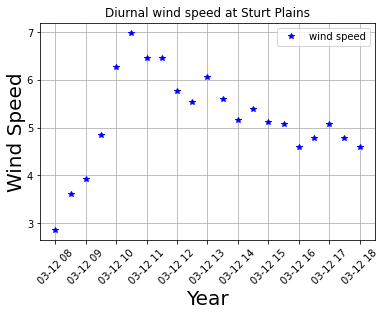

In [29]:
year=2018
month=3
d=12
df_all=spframe.copy()
df =df_all[(df_all.index.year == year) & (df_all.index.month == month) & (df_all.index.day == d) &(df_all.Fn > 25) & (df_all.Ws > 2) ]
plt.plot(df.index,df.Ws,"*",color= 'blue')
#plt.plot(df.index,df.Fld, ".",color= 'orange')
plt.xticks(rotation=45)
plt.xlabel('Year', ha='center',fontsize=20)
plt.ylabel('Wind Speed', labelpad=10, va='center',fontsize=20)
plt.legend(['wind speed'])
plottitle = 'Diurnal wind speed at Sturt Plains'
fname = 'wind speed at sturt plains'
plt.title(plottitle)
plt.grid()
#plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')

In [30]:
df=spframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_sp= df_inter.interpolate()
#Df_sp

In [31]:
mod_sp = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/strutplains_Lstdata.csv'
modis_sp = pd.read_csv(mod_sp)#engine='python',header=None)
modis_sp1=pd.DataFrame(modis_sp)
#print(modis_sp1)

In [32]:
mod_sp = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/strutplains_Lstdata.csv'
modis_sp = pd.read_csv(mod_sp)#engine='python',header=None)
modis_sp1=pd.DataFrame(modis_sp)
modis_sp1.index=modis_sp1.timestamp

###
df_mod=pd.to_datetime(modis_sp1.index)
#print(df_mod)

In [33]:
mod_sp = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/strutplains_Lstdata.csv'
modis_sp = pd.read_csv(mod_sp)#engine='python',header=None)
modis_sp1=pd.DataFrame(modis_sp)
modis_sp1.index=modis_sp1.timestamp

###
df_mod=pd.to_datetime(modis_sp1.index)### converting timestamp to 
#####
Dfec_mod=Df_sp.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_sp1.LST
Dfec_mod_sp=Dfec_mod.copy()
Dfec_mod_sp=Dfec_mod_sp.sort_index()

## Litchfield:

In [34]:
LF= '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/LST_epsilon/data/litchfield/' 
LFncfile = xr.open_mfdataset(LF +'/*.nc')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future defa

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [35]:
lfframe= LFncfile.to_dataframe()
lfframe.index=lfframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
lfframe.reset_index(inplace=True)
lfframe.index=lfframe.time
lfframe=lfframe[(lfframe.Fld_QCFlag==00)&(lfframe.Flu==00)]#&(lfframe.Fn_QCFlag==00)]
lfframe=lfframe.replace(-9999.000000, np.nan)
lfframe["T_a"] = pd.Series(lfframe.Ta + 273.15, index=lfframe.index)


/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [36]:
df=lfframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_lf= df_inter.interpolate()

In [37]:
mod_lf = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/litchfield_Lstdata.csv'
modis_lf = pd.read_csv(mod_lf)#engine='python',header=None)
modis_lf1=pd.DataFrame(modis_lf)
modis_lf1.index=modis_lf1.timestamp
###
df_mod=pd.to_datetime(modis_lf1.index)### converting timestamp to 
#####
Dfec_mod=Df_lf.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_lf1.LST
Dfec_mod_lf=Dfec_mod.copy()
Dfec_mod_lf=Dfec_mod_sp.sort_index()

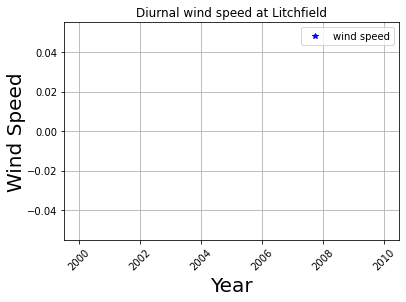

In [38]:
## wind speed at litchfield:
year=2018
month=12
d=12
df_all=lfframe.copy()
df =df_all[(df_all.index.year == year) & (df_all.index.month == month) & (df_all.index.day == d) &(df_all.Fn > 25) & (df_all.Ws > 2) ]
plt.plot(df.index,df.Ws,"*",color= 'blue')
#plt.plot(df.index,df.Fld, ".",color= 'orange')
plt.xticks(rotation=45)
plt.xlabel('Year', ha='center',fontsize=20)
plt.ylabel('Wind Speed', labelpad=10, va='center',fontsize=20)
plt.legend(['wind speed'])
plottitle = 'Diurnal wind speed at Litchfield'
fname = 'wind speed at litchfield'
plt.title(plottitle)
plt.grid()
#plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')

## adelaide River:

In [39]:
AR = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/LST_epsilon/data/AdelaideRiver/' 

ARncfile = xr.open_mfdataset(AR +'/*.nc')  #,combine='nested')


/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  This is separate from the ipykernel package so we can avoid doing imports until
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [40]:
arframe= ARncfile.to_dataframe()
arframe.index=arframe.index.set_names(['Time'])#'latitute', 'longitute'
arframe.reset_index(inplace=True)
arframe['timestamp']= pd.to_datetime(arframe[['Year' ,'Month','Day','Hour','Minute','Second']])
arframe.index=arframe.timestamp
arframe=arframe[(arframe.Fld_QCFlag==00)&(arframe.Flu_QCFlag==00)]#&(arframe.Fn_QCFlag==00)]
arframe=arframe.replace(-9999.000000, np.nan)
arframe["T_a"] = pd.Series(arframe.Ta + 273.15, index=arframe.index)


In [41]:
df=arframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws_CSAT","Fn"]].resample('min')
Df_ar= df_inter.interpolate()

In [42]:
mod_ar = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/Adelaide_LST.csv'
modis_ar = pd.read_csv(mod_ar)#engine='python',header=None)
modis_ar1=pd.DataFrame(modis_ar)
modis_ar1.index=modis_ar1.timestamp
###
df_mod=pd.to_datetime(modis_ar1.index)### converting timestamp to 
#####
Dfec_mod=Df_ar.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(df_mod)
Dfec_mod['modistemp']=modis_ar1.LST
Dfec_mod_ar=Dfec_mod.copy()
Dfec_mod_ar=Dfec_mod_ar.sort_index()

## titree

In [43]:
Titree = '/home/thakur_21505/Documents/git_projects/aerodynamic_conductances/jupyter/LST_epsilon/data/Ti_tree/' 
#print(path)
    
TTncfile = xr.open_mfdataset(Titree +'/*.nc') #, concat_dim= 'ensemble')


/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  after removing the cwd from sys.path.
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray v

In [44]:
titreeframe= TTncfile.to_dataframe()
titreeframe.index=titreeframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
titreeframe.reset_index(inplace=True)
titreeframe.index=titreeframe.time 
titreeframe=titreeframe[(titreeframe.Fld_QCFlag==00)&(titreeframe.Flu_QCFlag==00)]#&(titreeframe.Fn_QCFlag==00)&(titreeframe.Ws_QCFlag==00)]
titreeframe=titreeframe.replace(-9999.000000, np.nan)
titreeframe["T_a"] = pd.Series(titreeframe.Ta + 273.15, index=titreeframe.index)


### Interpolating datframe:

In [45]:
df=titreeframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws","Fn"]].resample('min')
Df_titree= df_inter.interpolate()
#df_inter_titre=Df1.copy ### copying interpolated dataframe 
#Df_titree

### modis data frame:

In [46]:
mod_titree = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/TiTree_Lstdata.csv'
modis_titree = pd.read_csv(mod_titree)#engine='python',header=None)
modis_titree1=pd.DataFrame(modis_titree)
modis_titree1.index=modis_titree1.timestamp
###
titree_mod=pd.to_datetime(modis_titree1.index)### converting timestamp to 
#####
Dfec_mod=Df_titree.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(titree_mod)
Dfec_mod['modistemp']=modis_titree1.LST
Dfec_mod_titree=Dfec_mod.copy()
Dfec_mod_titree=Dfec_mod_titree.sort_index()
#Dfec_mod_titree


## dryriver

In [47]:
dryriv = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/tern/dryriver/'
dryrivncfile = xr.open_mfdataset(dryriv +'/*.nc',compat='override',coords='all')#,combine='by_coords')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have 

In [48]:
dryrivframe= dryrivncfile.to_dataframe()
dryrivframe.index=dryrivframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
dryrivframe.reset_index(inplace=True)
dryrivframe.index=dryrivframe.time 
dryrivframe=dryrivframe[(dryrivframe.Flu_QCFlag==00)&(dryrivframe.Fld_QCFlag==00)]#&(dryrivframe.Fn_QCFlag==00)&(dryrivframe.Ws_CSAT_QCFlag==00)]
dryrivframe=dryrivframe.replace(-9999.000000, np.nan)
dryrivframe["T_a"] = pd.Series(dryrivframe.Ta + 273.15, index=dryrivframe.index)


In [49]:
df=dryrivframe.copy()
df_inter=df[["Fh", "Fld","Flu", "Ta","Ws_CSAT","Fn"]].resample('min')
Df_dryriv= df_inter.interpolate()

In [50]:
mod_titree = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/Modis_LST/Dryriv_Lstdata.csv'
modis_titree = pd.read_csv(mod_titree)#engine='python',header=None)
modis_titree1=pd.DataFrame(modis_titree)
modis_titree1.index=modis_titree1.timestamp
###
titree_mod=pd.to_datetime(modis_titree1.index)### converting timestamp to 
#####
Dfec_mod=Df_titree.copy()
Dfec_mod.index=pd.to_datetime(Dfec_mod.index)
Dfec_mod=Dfec_mod.reindex(titree_mod)
Dfec_mod['modistemp']=modis_titree1.LST
Dfec_mod_titree=Dfec_mod.copy()
Dfec_mod_titree=Dfec_mod_titree.sort_index()
#Dfec_mod_titree

## Daly uncleared

In [51]:
dalyunc = '/home/thakur_21505/lst-retrival-from-fluxnet-data/Data/tern/dalyuncleared/'
dalyuncncfile = xr.open_mfdataset(dalyunc +'/*.nc',compat='override',coords='all')

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future defa

In [52]:
dalyuncframe= dalyuncncfile.to_dataframe()
dalyuncframe.index=dalyuncframe.index.set_names(['longitute','latitute','time'])#'latitute', 'longitute'
dalyuncframe.reset_index(inplace=True)
dalyuncframe.index=dalyuncframe.time 
dalyuncframe=dalyuncframe[(dalyuncframe.Fld_QCFlag==00)&(dalyuncframe.Flu_QCFlag==00)]#&(dalyuncframe.Fn_QCFlag==00)&(dalyuncframe.Ws_CSAT_QCFlag==00)]
dalyuncframe=dalyuncframe.replace(-9999.000000, np.nan)
dalyuncframe["T_a"] = pd.Series(dalyuncframe.Ta + 273.15, index=dalyuncframe.index)


/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/xarray/coding/variables.py:141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv
/home/th

In [53]:
### plot of rah and Fpar:

## Variable def:

In [54]:
class epsilon (Variable):
    """emissivity """ 
    unit = 1 
    latex_name ='\epsilon'
    #default = 0.9

        
class sigma (Variable):
    """ stefan-boltzmann constant""" 
    unit =  watt/(meter**2 * kelvin**4)
    latex_name ='\sigma'
    default = 5.6704 * 10**-8


class T_s(Variable): 
    """Effective surface temperature.""" 
    unit = kelvin 
    latex_name ='T_{s}'
       
    
class T_a(Variable): 
    """Air temperature""" 
    unit = kelvin 
    latex_name ='T_a'   
 
    
class R_lout(Variable): 
    """upwelling longwave""" 
    unit = watt/meter**2
    latex_name ='R_{l,out}'
    #default = Hs.longwave_up
    
    
class H(Variable): 
    """sensible heat""" 
    unit = watt/meter**2
    latex_name ='H'
    
class delta_T(Variable): 
    """difference in surface and air temperature""" 
    unit = kelvin 
    latex_name ='\Delta T'

    

/home/thakur_21505/.conda/envs/essm/lib/python3.6/site-packages/essm/variables/_core.py:89: UserWarning: "essm.variables.physics.thermodynamics:T_a" will be overridden by "__main__:<class '__main__.T_a'>"
  instance[expr] = instance


In [55]:
# calculation of Ts considering both eitted and reflected radiation(Mike)
class R_lin(Variable):
    """Incoming Longwave radiation"""
    latex_name = r'R_{l,in}'
    unit = watt/meter**2
class eq_Rlout_Rlin(Equation):
    """Upwelling longwave radiation including reflected."""
    expr = Eq(R_lout, sigma*epsilon*T_s**4 + (1-epsilon) * R_lin)
eq_Rlout_Rlin

In [56]:
class eq_Ts_Rlout_Rlin(eq_Rlout_Rlin.definition):
    """Surface temperature as a function of LWout and LWin"""
    soln = solve(eq_Rlout_Rlin, T_s, dict=True)
    expr = Eq(T_s, soln[3][T_s])
eq_Ts_Rlout_Rlin

# equation Seq:

In [57]:
class eq_Rlout(Equation):
    """Upwelling longwave radiation."""
    expr = Eq(R_lout, sigma*epsilon*T_s**4)
eq_Rlout

In [58]:
class eq_Ts_Rlout(eq_Rlout.definition):
    """Surface temperature as a function of LWout"""
    soln = solve(eq_Rlout, T_s, dict=True)
    expr = Eq(T_s, soln[3][T_s])
eq_Ts_Rlout

## emissivity sensitivity:

In [59]:
def plot_eps_Ts_Ts1 (sitename,df_all,year,mnth,days,hours):
    """Two longwave formulation sensitivity to chosen emissivity"""
    
   
    df = df_all[(df_all.index.year == year) & (df_all.index.month == mnth) &(df_all.index.day == days)&
                (df_all.index.hour == hours)& (df_all.index.minute == 0)]
                #&(df_all.Fld_QCFlag==00)&(df_all.Flu_QCFlag==00)
                #&(df_all.Ta_QCFlag==00)&(df_all.Fh_QCFlag==00)]   
    epsilon1=np.arange(0.930,0.998,0.005)
    ign_rad=[]
    con_rad=[]
    for j in range(len(epsilon1)):
            
        tf_T_s1 = theano_function([R_lout], [eq_Ts_Rlout.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lout:1})
                                                       
            
        list_T_s1 = tf_T_s1(df.Flu)
        df = df.assign(T_s1=list_T_s1)
        tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        list_T_s = tf_T_s(df.Fld,df.Flu)
        df = df.assign(T_s=list_T_s)
           
            
        ign_rad.append(df.T_s1)
        con_rad.append(df.T_s)
    plt.figure(figsize=(8,6))
    plt.plot(epsilon1,ign_rad,"*",label='Short eq',color='k',markeredgewidth=3)
    plt.plot(epsilon1,con_rad,"+",label='Long eq',color='blue',markeredgewidth=3)#.format(list_months))
    plt.ylabel('$T_{s}$ (K)', ha='center',fontsize=20,)
    plt.xlabel('Emissivity ($\epsilon$)', labelpad=10, va='center',fontsize=20)
    #plt.title('{0} @ {1} h'.format(df.index[0].date().strftime('%Y/%m/%d'),hours))
    plt.xticks(np.arange(0.93,0.998,0.005), fontsize=20,rotation=45)
    plt.yticks(fontsize=20)
    plottitle = '{0} on {1} at midday'.format(str(sitename),
                                     (df.index[0].date().strftime('%Y/%m/%d')))
    fname = '{0},{1}'.format(str(sitename),
                      (str(np.round(year))))  #format(str(sitename)
    plt.title(plottitle)
    plt.grid()
    plt.tight_layout()
    plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
    plt.legend(fontsize=20)
    plt.show()
    
       


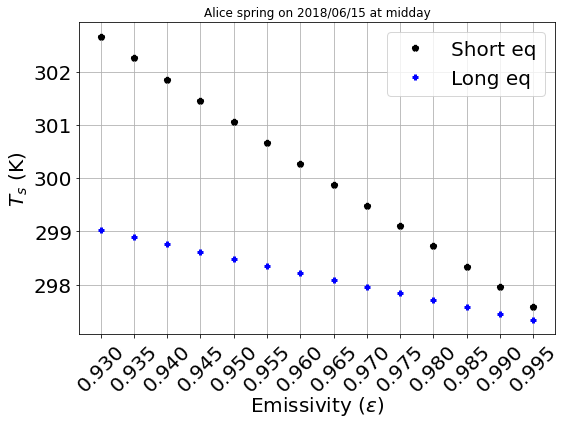

In [60]:
plot_eps_Ts_Ts1 ('Alice spring',asframe,2018,6,15,12)

**emissivity sensitivits at Alice spring**

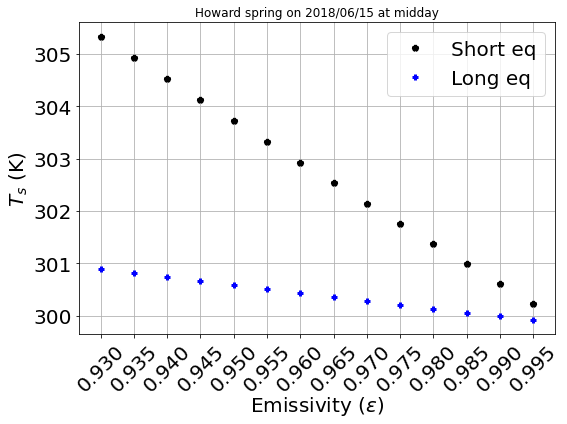

In [61]:
plot_eps_Ts_Ts1 ('Howard spring',hsframe,2018,6,15,12)

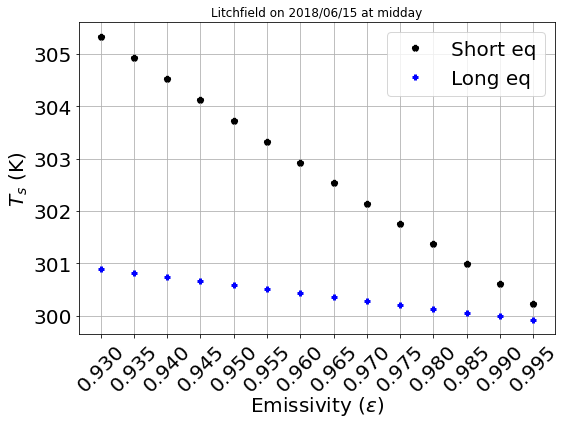

In [62]:
plot_eps_Ts_Ts1 ('Litchfield',hsframe,2018,6,15,12)

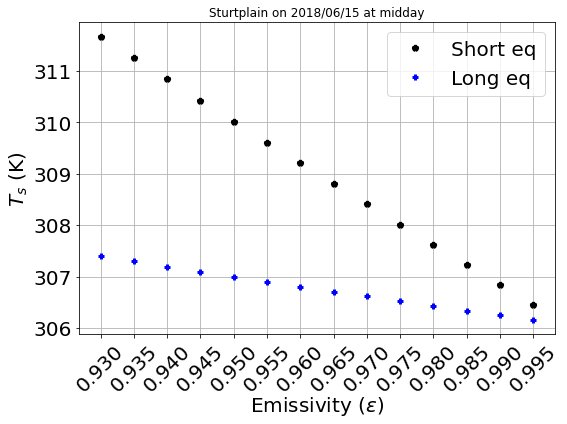

In [63]:
plot_eps_Ts_Ts1 ('Sturtplain',spframe,2018,6,15,12)

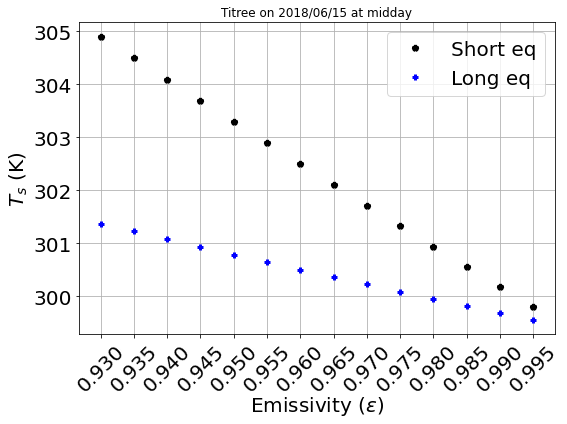

In [64]:
plot_eps_Ts_Ts1 ('Titree',titreeframe,2018,6,15,12)

In [65]:
#plot_eps_Ts_Ts1 ('Tumbarumba',tumframe,2016,7,15,12)

### Function for Ts estimation:

In [90]:
def Tslocal_leq (site,years,epsilon1):
    
    df_all = site.copy()
     # using array of the epsilon values
    df = df_all[(df_all.index.year == years)  & (df_all.Fn > 25) & (df_all.Ws_CSAT> 2)
        &(df_all.Fld_QCFlag==00)&(df_all.Flu_QCFlag==00)&(df_all.Fn_QCFlag==00)
                &(df_all.Ta_QCFlag==00)&(df_all.Fh_QCFlag==00)]
    ####
    
   
    tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        
        
  
        
        
    list_T_s = tf_T_s(df.Fld,df.Flu)
    df = df.assign(T_s=list_T_s)
    return(df.T_s)

In [91]:
def Tslocal_seq (site,years,epsilon1):
    """Plot a panel per month with H and delT."""
    
    df_all = site.copy()
     # using array of the epsilon values
    df = df_all[(df_all.index.year == years) & (df_all.Fn > 25) & (df_all.Ws_CSAT> 2)
         &(df_all.Fld_QCFlag==00)&(df_all.Flu_QCFlag==00)&(df_all.Fn_QCFlag==00)
                &(df_all.Ta_QCFlag==00)&(df_all.Fh_QCFlag==00)]
    ###
   
    tf_T_s1 = theano_function([R_lout], [eq_Ts_Rlout.rhs.subs(epsilon, epsilon1).
                                        subs(Variable.__defaults__)], dims={R_lout:1})
        
    
    list_T_s1 = tf_T_s1(df.Flu)
    df = df.assign(T_s1=list_T_s1)
        ##########
    return(df.T_s1)    

# LST  using MODIS epsilon:

## AS

In [80]:
Tsleq_as=Tslocal_leq (asframe,2016,0.974)
Tsseq_as=Tslocal_seq(asframe,2016,0.974)

In [81]:
min_seq_as=min(Tsseq_as)
max_seq_as=max(Tsseq_as)
min_leq_as=min(Tsleq_as)
max_leq_as=max(Tsleq_as)

## HS

In [82]:
Tsleq_hs=Tslocal_leq (hsframe,2016,0.985)
Tsseq_hs=Tslocal_seq(hsframe,2016,0.985)

In [83]:
min_seq_hs=min(Tsseq_hs)
max_seq_hs=max(Tsseq_hs)
min_leq_hs=min(Tsleq_hs)
max_leq_hs=max(Tsleq_hs)

In [84]:
print(min_seq_hs -min_leq_hs)

0.8637799040388927


In [85]:
print(max_seq_hs -max_leq_hs)

0.8898053886466641


**I checked the difference between the minimum and maximum at the two sites , it seems median value in the plot is a good representation of the temperature difference using the two equation**

## SP

In [86]:
Tsleq_sp=Tslocal_leq (spframe,2016,0.984)
Tsseq_sp=Tslocal_seq(spframe,2016,0.984)

## TItree

In [87]:
Tsleq_titree=Tslocal_leq (titreeframe,2016,0.974)
Tsseq_titree=Tslocal_seq(titreeframe,2016,0.974)

## LF

In [88]:
Tsleq_lf=Tslocal_leq (lfframe,2016,0.985)
Tsseq_lf=Tslocal_seq(lfframe,2016,0.985)

## Tumba

In [89]:
Tsleq_tum=Tslocal_leq (tumframe,2016,0.983)
Tsseq_tum=Tslocal_seq(tumframe,2016,0.983)

## AR
**ws is removed by Ws_csat**

In [92]:
Tsleq_ar=Tslocal_leq (arframe,2008,0.985)
Tsseq_ar=Tslocal_seq(arframe,2008,0.985)

## DR

In [93]:
Tsleq_dr=Tslocal_leq (dryrivframe,2016,0.985)
Tsseq_dr=Tslocal_seq(dryrivframe,2016,0.985)


## DU

In [94]:
Tsleq_du=Tslocal_leq (dalyuncframe,2016,0.985)
Tsseq_du=Tslocal_seq(dalyuncframe,2016,0.985)

## Tumba

## function Tseq and Tleq  for holmes site (yatir and brookings)
**The source of data is fluxnet, the variable name is different therefore a seprate function is defined for the two sites**

In [95]:
def Tslocal_leq1 (site,years,epsilon1):
    
    df_all = site.copy()
     # using array of the epsilon values
    df = df_all[(df_all.index.year == years)&(df_all.NETRAD > 25)& (df_all.WS > 2)]
    ####
    
   
    tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        
        
  
        
        
    list_T_s = tf_T_s(df.LW_IN,df.LW_OUT)
    df = df.assign(T_s=list_T_s)
    return(df.T_s)

In [96]:
def Tslocal_seq1 (site,years,epsilon1):
    """Plot a panel per month with H and delT."""
    
    df_all = site.copy()
     # using array of the epsilon values
    
    ###
    df = df_all[(df_all.index.year == years)&(df_all.NETRAD > 25)& (df_all.WS > 2)]
    tf_T_s1 = theano_function([R_lout], [eq_Ts_Rlout.rhs.subs(epsilon, epsilon1).
                                        subs(Variable.__defaults__)], dims={R_lout:1})
        
    
    list_T_s1 = tf_T_s1(df.LW_OUT)
    df = df.assign(T_s1=list_T_s1)
        ##########
    return(df.T_s1)

### Brookings

In [97]:
Tsleq_brook=Tslocal_leq1 (brookframe,2005,0.983)
Tsseq_brook=Tslocal_seq1(brookframe,2005,0.983)

### Yatir

In [98]:
Tsleq_yatir=Tslocal_leq1 (yatframe,2005,0.974)
Tsseq_yatir=Tslocal_seq1(yatframe,2005,0.974)

## windspeed timeseries:

In [99]:
#hsframe.Ws

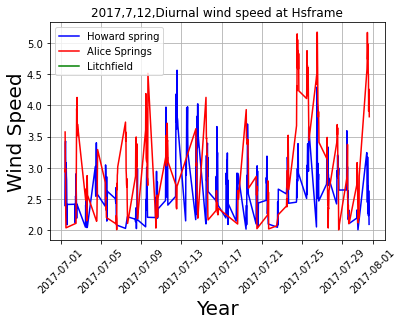

In [100]:
year=2017
month=7
hourmax=15
hourmin=10
df_all=hsframe.copy()
df_all1=asframe.copy()
df_all2=lfframe.copy()
df_all3=tumframe.copy()


df =df_all[(df_all.index.year == year) & (df_all.index.month == month)& (df_all.index.hour >= hourmin)& 
           (df_all.index.hour <= hourmax) &(df_all.Fn > 25) & (df_all.Ws > 2) ]
df1 =df_all1[(df_all1.index.year == year) & (df_all1.index.month == month)& (df_all1.index.hour >= hourmin)& 
           (df_all1.index.hour <= hourmax) &(df_all1.Fn > 25) & (df_all1.Ws > 2) ]
df2 =df_all2[(df_all2.index.year == year) & (df_all2.index.month == month)& (df_all2.index.hour >= hourmin)&
           (df_all2.index.hour <= hourmax) &(df_all2.Fn > 25) & (df_all2.Ws > 2) ]
plt.plot(df.index,df.Ws,color= 'blue')
plt.plot(df1.index,df1.Ws,color= 'red')
plt.plot(df2.index,df2.Ws,color= 'green')
plt.xticks(rotation=45)
plt.xlabel('Year', ha='center',fontsize=20)
plt.ylabel('Wind Speed', labelpad=10, va='center',fontsize=20)
plt.legend(['Howard spring','Alice Springs','Litchfield'])
plottitle ='{0},{1},{2},Diurnal wind speed at Hsframe'.format(str(year),
                                                             str(month),
                                                             str(d)) #df.index[0].date().strftime
fname = 'wind speed at North Australian sites'.format(df.index[0].date().strftime('%Y/%m/%d'))
plt.title(plottitle)
plt.grid()
#plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')

## Tumbarumba

windsped_hour('Tumbarumba',tumframe,2017,hourmax=17,hourmin=10)

## 2D array

In [101]:
#month=12
hourmax=17
hourmin=10
df_all=hsframe.copy()
df_all1=asframe.copy()
df_all2=lfframe.copy()
df_all3=tumframe.copy()
####################
ws_hr=[]
hrs_test= np.arange(hourmin,hourmax)
###########
ii=0
z=[[0 for row in range(0,12)] for col in range(0,7)]
for j in range(0,3):
    for i in range(0,7):
    
        df =df_all[(df_all.index.year == year) & (df_all.index.month == j+1)& (df_all.index.hour == hrs_test[i])& (df_all.index.minute == 0)]
        ws_hr.append(df.Ws)
        z[j][i]=ws_hr
        

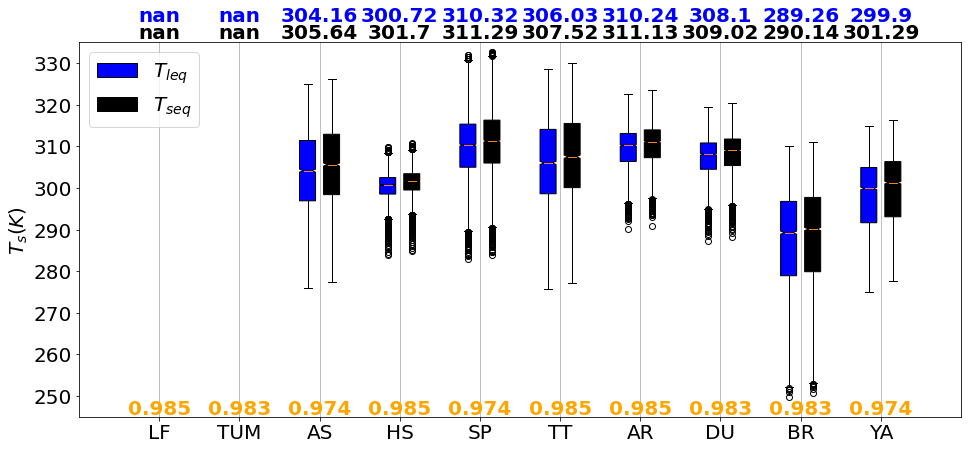

In [102]:
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.canvas.set_window_title('temp bias boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([Tsleq_lf,Tsleq_tum,Tsleq_as,Tsleq_hs,
                Tsleq_sp,Tsleq_titree,Tsleq_ar,Tsleq_du,Tsleq_brook,Tsleq_yatir.dropna()],1,widths=0.2,patch_artist=True,
                positions=np.arange(0.85,10.85))
### box plot using short equation
box1=plt.boxplot([Tsseq_lf,Tsseq_tum,Tsseq_as,Tsseq_hs,
                Tsseq_sp,Tsseq_titree,Tsseq_ar,Tsseq_du,Tsseq_brook,Tsseq_yatir.dropna()],1,widths=0.2,patch_artist=True,
                 positions=np.arange(1.15,11.15))
               
               
               
               
plt.setp(box["boxes"], facecolor='blue')
plt.setp(box1["boxes"], facecolor='black')
plt.legend([box["boxes"][0],box1["boxes"][0]],
           ["$T_{leq}$", "$T_{seq}$"],loc="upper left", fontsize=20) 
#colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen','red', 'pink']
#for patch, color in zip(box['boxes'], colors):
        #patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Tmodis -Tleq')
#ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{s}(K)$', ha='center',fontsize=20)

numBoxes=10
medians=list(range(numBoxes))
medians1=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    med1 = box1['medians'][i]
    medianX = []
    medianY = []
    medianX1 = []
    medianY1 = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        medianX1.append(med1.get_xdata()[j])
        medianY1.append(med1.get_ydata()[j])
        plt.plot(medianX, medianY)
        plt.plot(medianX1, medianY1)
        medians[i] = medianY[0]
        medians1[i] = medianY1[0]
        #medians[i] = medianx[0]
# Set the axes ranges and axes labels
eps=[0.985,0.983,0.974,0.985,0.974,0.985,0.985,0.983,0.983,0.974]
ax1.set_xlim(0, numBoxes+1)
top = 335
bottom = 245
ax1.set_ylim(bottom, top)
ax1.yaxis.set_tick_params(labelsize=20)
#xtickNames = plt.setp(ax1, xticklabels=("Litchfield","Tumbarumba","Alice Spring",
                                       # "Howard Spring","Sturt Plains","Titree east",
                                       #"Adelaide River", "Dalyuncleared","Brookings","Yatir"))
#plt.setp(xtickNames, rotation=45, fontsize=12, fontweight='bold')
plt.xticks(np.arange(1,11), ("LF","TUM","AS","HS","SP","TT","AR","DU","BR","YA"),fontsize=20)#,fontweight='bold')


pos = np.arange(1,11)
upperLabels = [str(np.round(s, 2)) for s in medians]
upperLabels1 = [str(np.round(s1, 2)) for s1 in medians1]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top+5, upperLabels[tick],
             horizontalalignment='center', weight=weights[k],
             color='b',fontsize=20)
    ax1.text(pos[tick], top +1, upperLabels1[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='black',fontsize=20)
    ax1.text(pos[tick], bottom + 0.5, eps[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='orange',fontsize=20)
plt.grid()
fname = 'local_leq_seq'
plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

        
    

**Figure 3 of the paper showing yearly range of surface-air temperature difference at the study sites using landscale-scale MODIS based emissivity**

## Ts -Ta for all sites (stan's comment on draft1)

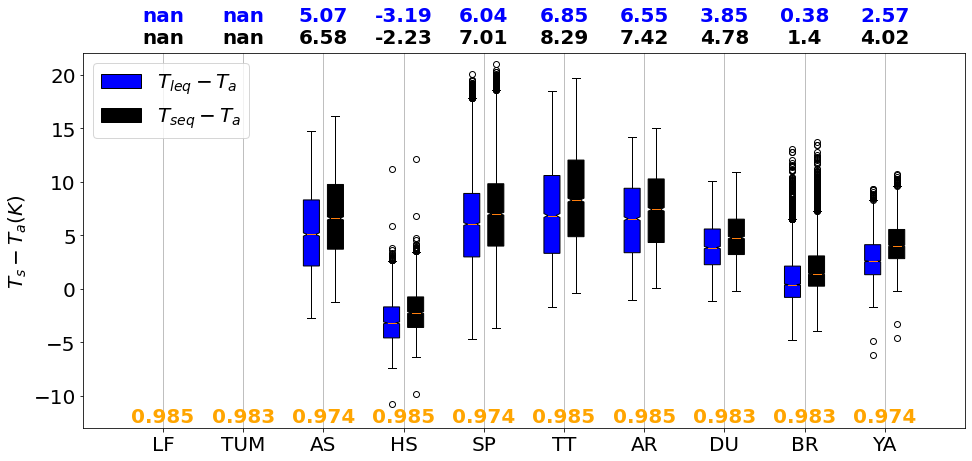

In [103]:
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.canvas.set_window_title('Ts - Ta boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([(Tsleq_lf-lfframe.T_a).dropna(),(Tsleq_tum - tumframe.T_a).dropna(),(Tsleq_as - asframe.T_a).dropna()
                ,(Tsleq_hs - hsframe.T_a).dropna(),(Tsleq_sp -spframe.T_a).dropna(),(Tsleq_titree -titreeframe.T_a).dropna(),(Tsleq_ar-arframe.T_a).dropna(),
                 (Tsleq_du - dalyuncframe.T_a).dropna(),(Tsleq_brook - brookframe.T_a).dropna(),
                 (Tsleq_yatir - yatframe.T_a).dropna()],1,widths=0.2,patch_artist=True,positions=np.arange(0.85,10.85))
### box plot using short equation
box1=plt.boxplot([(Tsseq_lf - lfframe.T_a).dropna(),(Tsseq_tum - tumframe.T_a).dropna(),(Tsseq_as - asframe.T_a).dropna()
                  ,(Tsseq_hs - hsframe.T_a).dropna(),(Tsseq_sp - spframe.T_a).dropna(),(Tsseq_titree -titreeframe.T_a).dropna()
                  ,(Tsseq_ar- arframe.T_a).dropna()
                  ,(Tsseq_du - dalyuncframe.T_a).dropna(),(Tsseq_brook - brookframe.T_a).dropna(),
                  (Tsseq_yatir - yatframe.T_a).dropna()],1,widths=0.2,patch_artist=True,
                 positions=np.arange(1.15,11.15))
               
               
               
               
plt.setp(box["boxes"], facecolor='blue')
plt.setp(box1["boxes"], facecolor='black')
plt.legend([box["boxes"][0],box1["boxes"][0]],
           ["$T_{leq} - T_{a}$", "$T_{seq} - T_{a}$"],loc="upper left", fontsize=20) 
#colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen','red', 'pink']
#for patch, color in zip(box['boxes'], colors):
        #patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Tmodis -Tleq')
#ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{s} - T_{a}(K)$', ha='center',fontsize=20, fontweight='bold')

numBoxes=10
medians=list(range(numBoxes))
medians1=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    med1 = box1['medians'][i]
    medianX = []
    medianY = []
    medianX1 = []
    medianY1 = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        medianX1.append(med1.get_xdata()[j])
        medianY1.append(med1.get_ydata()[j])
        plt.plot(medianX, medianY)
        plt.plot(medianX1, medianY1)
        medians[i] = medianY[0]
        medians1[i] = medianY1[0]
        #medians[i] = medianx[0]
# Set the axes ranges and axes labels
eps=[0.985,0.983,0.974,0.985,0.974,0.985,0.985,0.983,0.983,0.974]
ax1.set_xlim(0, numBoxes+1)
top = 22
bottom = -13
ax1.set_ylim(bottom, top)
ax1.yaxis.set_tick_params()
#xtickNames = plt.setp(ax1, xticklabels=("Litchfield","Tumbarumba","Alice Spring",
                                       # "Howard Spring","Sturt Plains","Titree east",
                                       #"Adelaide River", "Dalyuncleared","Brookings","Yatir"))
#plt.setp(xtickNames, rotation=45, fontsize=12, fontweight='bold')
plt.xticks(np.arange(1,11), ("LF","TUM","AS","HS","SP","TT","AR","DU","BR","YA")
           ,fontsize=20)
plt.yticks(fontsize= 20)


pos = np.arange(1,11)
upperLabels = [str(np.round(s, 2)) for s in medians]
upperLabels1 = [str(np.round(s1, 2)) for s1 in medians1]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top +3, upperLabels[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='b', fontsize=20)
    ax1.text(pos[tick], top +1, upperLabels1[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='black', fontsize=20)
    ax1.text(pos[tick], bottom + 0.5, eps[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='orange',fontsize=20)
plt.grid()
fname = 'Ts_Talocalleqseq'
plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

        
        

**surface to air temperature difference **

## LST sensitivity to emissivity

In [104]:
def plot_eps_Ts_Ts1 (site,df_all,year,mnth,days,hours):
    """Two longwave formulation sensitivity to chosen emissivity"""
    
   
    df = df_all[(df_all.index.year == year) & (df_all.index.month == mnth) &(df_all.index.day == days)
                &  (df_all.index.hour == hours)& (df_all.index.minute == 0)]
                #&(df_all.Fld_QCFlag==00)&(df_all.Flu_QCFlag==00)
                #&(df_all.Ta_QCFlag==00)&(df_all.Fh_QCFlag==00)]   
    epsilon1=np.arange(0.93,1,0.005)
    ign_rad=[]
    con_rad=[]
    for j in range(len(epsilon1)):
            
        tf_T_s1 = theano_function([R_lout], [eq_Ts_Rlout.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lout:1})
                                                       
            
        list_T_s1 = tf_T_s1(df.Flu)
        df = df.assign(T_s1=list_T_s1)
        tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        list_T_s = tf_T_s(df.Fld,df.Flu)
        df = df.assign(T_s=list_T_s)
           
            
        ign_rad.append(df.T_s1)
        con_rad.append(df.T_s)
        
    
    ign_rad1=(np.array(ign_rad)).flatten()
    con_rad1=(np.array(con_rad)).flatten()
    return(ign_rad1,con_rad1)
       


In [105]:
#print(Tsseq_ar)

In [106]:
#As
Ts_as=plot_eps_Ts_Ts1 ('Alice Springs',asframe,2016,6,15,12)[0]
Tl_as=plot_eps_Ts_Ts1 ('Alice Springs',asframe,2016,6,15,12)[1]
#Ts_as=(np.array(Ts_as)).flatten()
#print(Ts_as)
#plt.boxplot(Ts_as)

In [107]:
#hs
Ts_hs=plot_eps_Ts_Ts1 ('Howard Springs',hsframe,2016,6,15,12)[0]
Tl_hs=plot_eps_Ts_Ts1 ('Howard Springs',hsframe,2016,6,15,12)[1]

In [108]:
Ts_lf=plot_eps_Ts_Ts1 ('Litchfield',lfframe,2016,6,15,12)[0]
Tl_lf=plot_eps_Ts_Ts1 ('Litchfield',lfframe,2016,6,15,12)[1]

In [109]:
Ts_sp=plot_eps_Ts_Ts1 ('Sturt plains',spframe,2016,6,15,12)[0]
Tl_sp=plot_eps_Ts_Ts1 ('Sturt plains',spframe,2016,6,15,12)[1]

In [110]:
Ts_ar=plot_eps_Ts_Ts1 ('Adelaide river',arframe,2008,6,15,12)[0]
Tl_ar=plot_eps_Ts_Ts1 ('Adelaide river',arframe,2008,6,15,12)[1]

In [111]:
Ts_tt=plot_eps_Ts_Ts1 ('titree',titreeframe,2016,6,15,12)[0]
Tl_tt=plot_eps_Ts_Ts1 ('titree',titreeframe,2016,6,15,12)[1]

In [112]:
Ts_du=plot_eps_Ts_Ts1 ('dalyuncleared',dalyuncframe,2016,6,15,12)[0]
Tl_du=plot_eps_Ts_Ts1 ('dalyuncleared',dalyuncframe,2016,6,15,12)[1]

In [113]:
Ts_tum=plot_eps_Ts_Ts1 ('Tumbarumba',tumframe,2016,6,15,12)[0]
Tl_tum=plot_eps_Ts_Ts1 ('Tumbarumba',tumframe,2016,6,15,12)[1]

### eps from 0.93 to 1

In [ ]:
#epsilon1=np.arange(1,0.93,-0.005)

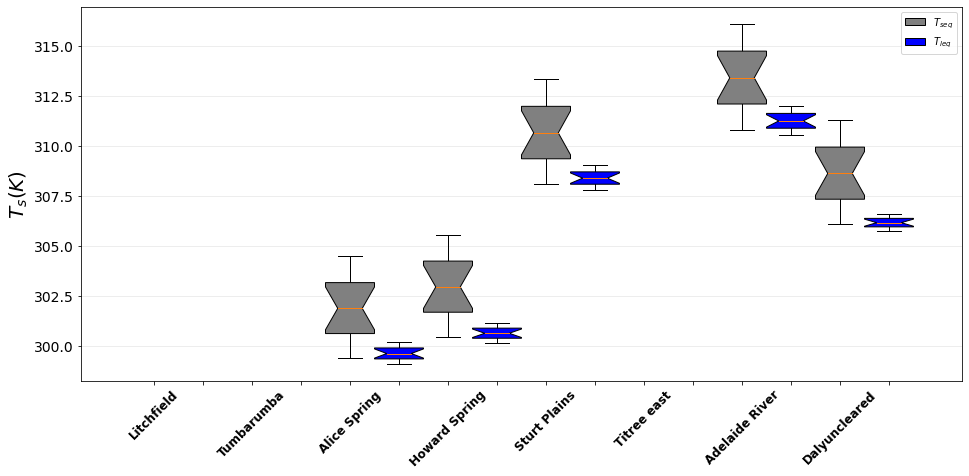

In [114]:
fig, ax1 = plt.subplots(figsize=(14, 8))
fig.canvas.set_window_title('temp bias boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([Ts_lf,Ts_tum,Ts_as,Ts_hs,
                Ts_sp,Ts_tum,Ts_ar,Ts_du],1,patch_artist=True,positions=np.arange(0.75,8.75))
### box plot using short equation
box1=plt.boxplot([Tl_lf,Tl_tum,Tl_as,Tl_hs,
                Tl_sp,Tl_tum,Tl_ar,Tl_du],1,patch_artist=True,positions=np.arange(1.25,9.25))
               
               
               
               
plt.setp(box["boxes"], facecolor='grey')
plt.setp(box1["boxes"], facecolor='blue')
plt.legend([box["boxes"][0],box1["boxes"][0]],
           ["$T_{seq}$", "$T_{leq}$"],loc="best") 
#colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen','red', 'pink']
#for patch, color in zip(box['boxes'], colors):
        #patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Tmodis -Tleq')
#ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{s}(K)$', ha='center',fontsize=20)

numBoxes=8
medians=list(range(numBoxes))
medians1=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    med1 = box1['medians'][i]
    medianX = []
    medianY = []
    medianX1 = []
    medianY1 = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        medianX1.append(med1.get_xdata()[j])
        medianY1.append(med1.get_ydata()[j])
        plt.plot(medianX, medianY)
        plt.plot(medianX1, medianY1)
        medians[i] = medianY[0]
        medians1[i] = medianY1[0]
        #medians[i] = medianx[0]
# Set the axes ranges and axes labels
eps=[0.985,0.983,0.974,0.985,0.984,0.974,0.985,0.985,0.985]
ax1.set_xlim(0, numBoxes + 1)
#top = 340
#bottom = 263
#ax1.set_ylim(bottom, top)
ax1.yaxis.set_tick_params(labelsize=14)
xtickNames = plt.setp(ax1, xticklabels=("Litchfield","Tumbarumba","Alice Spring",
                                        "Howard Spring","Sturt Plains","Titree east",
                                       "Adelaide River", "Dalyuncleared"))
plt.setp(xtickNames, rotation=45, fontsize=12, fontweight='bold')


pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
upperLabels1 = [str(np.round(s1, 2)) for s1 in medians1]
weights = ['bold', 'semibold']
#for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    #k = tick % 2
    #ax1.text(pos[tick], top - 3, upperLabels[tick],
             #horizontalalignment='center', size='x-large', weight=weights[k],
             #color='b')
    #ax1.text(pos[tick], top - 6, upperLabels1[tick],
             #horizontalalignment='center', size='x-large', weight=weights[k],
             #color='grey')
    #ax1.text(pos[tick], bottom + 4, eps[tick],
             #horizontalalignment='center', size='x-large', weight=weights[k],
             #color='k')

fname = 'LST_sensitivity'
plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

plt.show()

        
        

## function seq:

In [137]:
def seq_modis ( df_all,epsilon1):
    
    
     
    df = df_all[(df_all.Fn > 25) & (df_all.Ws_CSAT> 2)]
   
    
   
    tf_T_s1 = theano_function([R_lout], [eq_Ts_Rlout.rhs.subs(epsilon, epsilon1).
                                                          subs(Variable.__defaults__)], dims={R_lout:1})
        
                                        
    list_T_s1 = tf_T_s1(df.Flu)
    df = df.assign(T_s1=list_T_s1)
        ##########
        
    df = df.assign(Tbias_seq=(df.modistemp - df.T_s1 ))
    return(df.Tbias_seq)  
    

# Function Leq:

In [138]:
def leq_modis ( df_all,epsilon1):
    
    
     
    df = df_all[(df_all.Fn > 25) & (df_all.Ws_CSAT> 2)]
   
    
   
    tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        
        
    
        
    list_T_s = tf_T_s(df.Fld,df.Flu)
    df = df.assign(T_s=list_T_s)
    df = df.assign(Tbias=(df.modistemp - df.T_s ))
    return(df.Tbias)  
    

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text major ticklabel objects>)

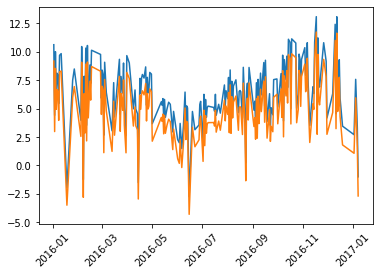

In [122]:
bias_as=leq_modis (Dfec_mod_as ,0.974)
bias_seq_as=seq_modis(Dfec_mod_as ,0.974)
plt.plot(bias_as)
plt.plot(bias_seq_as)
plt.xticks(rotation=45)

(array([736055., 736146., 736238., 736330., 736420., 736511., 736603.,
        736695., 736785., 736876., 736968.]),
 <a list of 11 Text major ticklabel objects>)

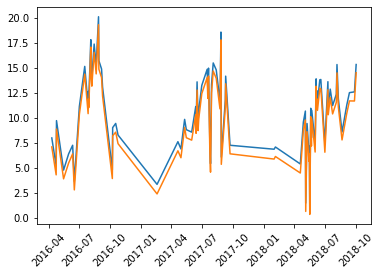

In [123]:
bias_hs=leq_modis (Dfec_mod_hs ,0.986)
bias_seq_hs=seq_modis(Dfec_mod_hs,0.986)
plt.plot(bias_hs)
plt.plot(bias_seq_hs)
plt.xticks(rotation=45)

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text major ticklabel objects>)

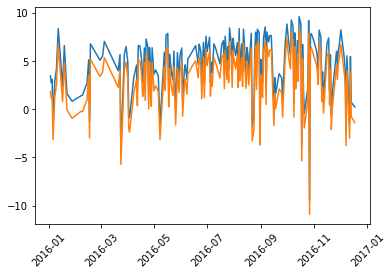

In [132]:
bias_sp=leq_modis (Dfec_mod_sp ,0.974)
bias_seq_sp=seq_modis (Dfec_mod_sp ,0.974)
plt.plot(bias_sp)
plt.plot(bias_seq_sp)
plt.xticks(rotation=45)

(array([735964., 736024., 736085., 736146., 736208., 736269., 736330.]),
 <a list of 7 Text major ticklabel objects>)

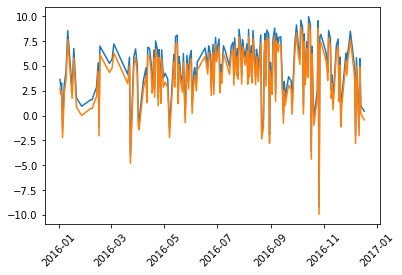

In [133]:
bias_lf=leq_modis (Dfec_mod_lf ,0.986)
bias_seq_lf=seq_modis (Dfec_mod_lf ,0.986)
plt.plot(bias_lf)
plt.plot(bias_seq_lf)
plt.xticks(rotation=45)

(array([735964., 736085., 736208., 736330., 736450., 736573., 736695.,
        736815., 736938., 737060.]),
 <a list of 10 Text major ticklabel objects>)

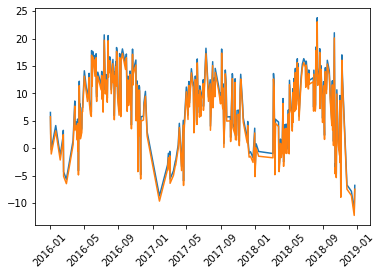

In [134]:
bias_titree=leq_modis (Dfec_mod_titree ,0.986)
bias_seq_titree=seq_modis (Dfec_mod_titree ,0.986)
plt.plot(bias_titree)
plt.plot(bias_seq_titree)
plt.xticks(rotation=45)

(array([729390., 730120., 730851., 731581., 732312., 733042., 733773.]),
 <a list of 7 Text major ticklabel objects>)

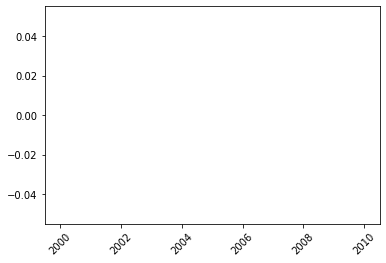

In [135]:
### wind speed variable name is different

bias_tum=leq_modis (Dfec_mod_tum ,0.986)
bias_seq_tum=seq_modis (Dfec_mod_tum ,0.986)
plt.plot(bias_tum)
plt.plot(bias_seq_tum)
plt.xticks(rotation=45)

(array([733042., 733102., 733163., 733224., 733286., 733347., 733408.,
        733467., 733528.]),
 <a list of 9 Text major ticklabel objects>)

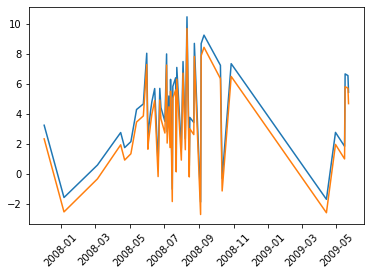

In [139]:
bias_ar=leq_modis (Dfec_mod_ar ,0.986)
bias_seq_ar=seq_modis(Dfec_mod_ar,0.986)
plt.plot(bias_ar)
plt.plot(bias_seq_ar)
plt.xticks(rotation=45)

# Bias plot using landscape-scale emissivity :

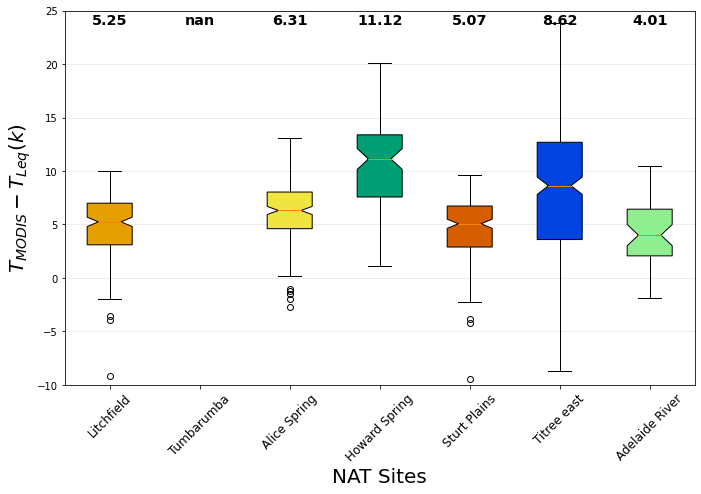

In [140]:
fig, ax1 = plt.subplots(figsize=(10, 8))
fig.canvas.set_window_title('temp bias boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([bias_lf,bias_tum,
                bias_as,bias_hs,
                bias_sp,bias_titree,
                bias_ar],1,patch_artist=True)
               
               


colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen']
for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Tmodis -Tleq')
ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{MODIS} -T_{Leq}(k)$', ha='center',fontsize=20)

numBoxes=7
medians=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
top = 25
bottom = -10
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=("Litchfield","Tumbarumba","Alice Spring",
                                        "Howard Spring","Sturt Plains","Titree east",
                                       "Adelaide River"))
plt.setp(xtickNames, rotation=45, fontsize=12)


pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='k')



plt.show()

        
        

**Plot showing bias using long equation with landscape scale emissivity**

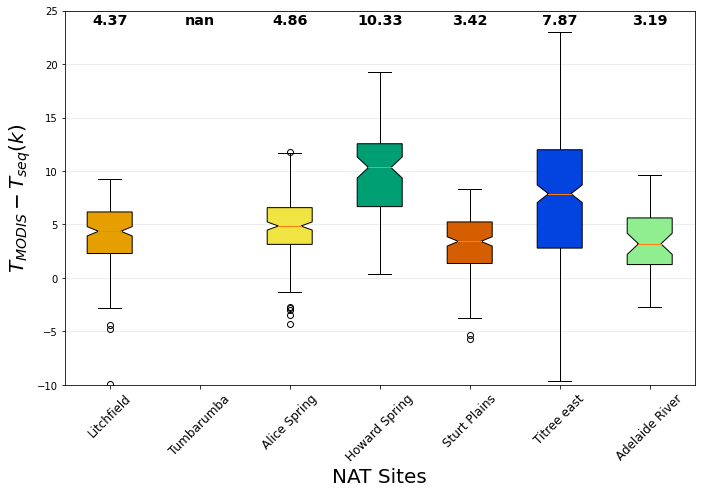

In [141]:
fig, ax1 = plt.subplots(figsize=(10, 8))
fig.canvas.set_window_title('temp bias boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([bias_seq_lf,bias_seq_tum,
                bias_seq_as,bias_seq_hs,
                bias_seq_sp,bias_seq_titree,
                bias_seq_ar],1,patch_artist=True)
               
               


colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen']
for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Tmodis -Tseq')
ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{MODIS} -T_{seq}(k)$', ha='center',fontsize=20)

numBoxes=7
medians=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
top = 25
bottom = -10
ax1.set_ylim(bottom, top)
xtickNames = plt.setp(ax1, xticklabels=("Litchfield","Tumbarumba","Alice Spring",
                                        "Howard Spring","Sturt Plains","Titree east",
                                       "Adelaide River"))
plt.setp(xtickNames, rotation=45, fontsize=12)


pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='k')



plt.show()

        
        

#  Bias plot using monthly plot-scale emissivity 

### opt eps plot:

In [160]:

def opteps_RLM (years, df_all,mnth,xcol = 'DT', ycol = 'Fh', eqdigits=3):
    opteps_rlm = pd.DataFrame(columns=["RMSE", "m","eps_ref","R2"])
    k=0
    epsilon1=np.arange(0.998,0.4,-0.002).tolist() # using array of the epsilon values
    df = df_all[(df_all.index.year == years) & (df_all.index.month == mnth)& 
                (df_all.Fn > 25) & (df_all.Ws > 2)]
    
    
    for j in range(len(epsilon1)) :
        tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
                                                       
        
        
        tf_T_s2 = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[j]).
                                                          subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})
        
        list_T_s = tf_T_s(df.Fld,df.Flu)
        df = df.assign(T_s=list_T_s)
        list_H = df.Fh
        list_DT = df.T_s - df.T_a
        df = df.assign(DT=(df.T_s - df.T_a)) 
        
        try:
            
            df1 = df.dropna(subset=[xcol, ycol])# for removing nan values
            xdata1 = df1[xcol]
            ydata1 = df1[ycol]
            x=np.array(xdata1)
            y=np.array(ydata1)
            x=x.reshape(-1,1)
            y=y.reshape(-1,1)
            reg=LinearRegression(fit_intercept=False).fit(x, y) ## 2d x
        except ValueError: 
            
            r2=0                  ## for months having no data
        else:
            m=float(reg.coef_)
            c= float(reg.intercept_)
            y_pred = m*x+c
            N=len(y)
            MSE= mean_squared_error(y,y_pred)
            RMSE=float(sqrt(MSE))
            r2=r2_score(y,y_pred)
    
        if r2 > 0.5:
            opteps_rlm.loc[k]=[RMSE, m, epsilon1[j], r2]
        else:
            opteps_rlm.loc[k]=[np.nan, np.nan, 1, r2]
        k=k+1
        
        
        
    df_eps_ref=opteps_rlm.copy()## copying data frame for sorting based on minimum rmse
    
    df_eps_ref.sort_values(by=['RMSE'],ascending=True,inplace=True)
    
    return(df_eps_ref.eps_ref.iloc[0],df_eps_ref.m.iloc[0])
        
            

In [143]:
def opteps_leqlist(site,startyr,endyr):
    

    df=site.copy()
    mnth=0                              #8,9,10,11,12
    for yr in range(startyr,endyr+1):
    
        list_opteps_ref=[]
        for i in range(12):
            mnth=i+1
            opteps_ref = pd.DataFrame(columns=["RMSE", "m","eps_ref","R2"])
            loop_result=opteps_RLM (yr,df,mnth)
            opt_eps=loop_result[0]
       
            if opt_eps < 1:
                list_opteps_ref.append(opt_eps)
            
            else:
                list_opteps_ref.append(1)
            
        if yr == startyr:
            list_opt_epsref1=list_opteps_ref.copy()
        if yr == startyr +1 :
            list_opt_epsref2=list_opteps_ref.copy()
        if yr == endyr:
            list_opt_epsref3=list_opteps_ref.copy() 
    return(list_opt_epsref1,list_opt_epsref2, list_opt_epsref3)
    

In [144]:
def opteps_leq_bias(df_all,yr_start,yr_end,list_optref1,list_optref2,list_optref3):
    optTs_leq=[]
    leq_bias_list=[]
    df_all= df_all.dropna(subset=['modistemp','Fld','Flu'])  
    list_months= list(range(1,13))

    for yr in range(yr_start,yr_end+1):
    
    
        for i in range(12):
            if yr == yr_start:
                epsilon1= list_optref1
            
            elif yr == yr_start + 1:
            
                epsilon1=list_optref2
           
            elif yr == yr_end:
                epsilon1=list_optref3
            
            if epsilon1[i]!= 1:
                df = df_all[(df_all.index.year == yr) & 
                            (df_all.index.month == list_months[i])]

                tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[i]).
                                                              subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})

                list_T_s = tf_T_s(df.Fld,df.Flu)
                df = df.assign(T_s=list_T_s)
                df = df.assign(Topt_leqbias=(df.modistemp - df.T_s ))
                #print(df.Topt_leqbias)
                
            else :
                df = df_all[(df_all.index.year == yr) & (df_all.index.month == list_months[i])]
                df = df.assign(Topt_leqbias=(np.nan))
            #print(df.Topt_leqbias)
            leq_bias_list1=df.Topt_leqbias.tolist()
            leq_bias_list.append(leq_bias_list1)
    return(leq_bias_list)      

In [145]:
Hs_optlist=opteps_leqlist(hsframe,2016,2018)

hs_leq_bias=opteps_leq_bias(Dfec_mod_hs,2016,2018,Hs_optlist[0],Hs_optlist[1],Hs_optlist[2])
hs_leq_bias1=list(flatten(hs_leq_bias))
hs_leq_bias1=np.array(hs_leq_bias1)
hs_leq_bias2=hs_leq_bias1[~np.isnan(hs_leq_bias1)]
print(hs_leq_bias2)


[ -1.13320912   0.18526819  -3.51296308   1.12698312   0.71831251
  -1.6991725    3.2994559    1.2258057    6.18554911   8.37200224
   2.52546194   3.54305583   7.83155547   7.174012     5.97459728
   8.13810943   4.67843111   9.57907626   8.16657304   5.27087206
   7.93592819   3.39026573   5.32828678  10.43694208  -4.33013167
   2.9292822    2.6040972    5.8715303    6.43516386  -4.83033368
   7.08677499   1.00729437   5.90018353   3.12936406   3.17936703
   1.75105305   1.09585965   3.7724692   -8.40744588  -0.79119587
  -4.10722723  -5.22576035  -2.99541533 -10.78510942   2.27745041
  -1.91499043   2.33692428   0.16341316   4.11274172   2.62637717
   5.44047451   5.56000354   7.20189516  10.90297106   3.52159731
  11.24583561   1.99464655   0.98916872   5.63056815   7.65878025
   2.90900395  -3.46463278  12.92437864   6.8092125    0.39579321
  -0.27895777  -7.10418039   7.2560612   -8.50891729   1.27015932
  -3.83155652  -5.21618763   4.1219631    0.79180741   1.1100466
   0.727388

In [146]:
hs_leq_bias1=np.array(hs_leq_bias1)
hs_leq_bias2=hs_leq_bias1[~np.isnan(hs_leq_bias1)]
print(hs_leq_bias2)

[ -1.13320912   0.18526819  -3.51296308   1.12698312   0.71831251
  -1.6991725    3.2994559    1.2258057    6.18554911   8.37200224
   2.52546194   3.54305583   7.83155547   7.174012     5.97459728
   8.13810943   4.67843111   9.57907626   8.16657304   5.27087206
   7.93592819   3.39026573   5.32828678  10.43694208  -4.33013167
   2.9292822    2.6040972    5.8715303    6.43516386  -4.83033368
   7.08677499   1.00729437   5.90018353   3.12936406   3.17936703
   1.75105305   1.09585965   3.7724692   -8.40744588  -0.79119587
  -4.10722723  -5.22576035  -2.99541533 -10.78510942   2.27745041
  -1.91499043   2.33692428   0.16341316   4.11274172   2.62637717
   5.44047451   5.56000354   7.20189516  10.90297106   3.52159731
  11.24583561   1.99464655   0.98916872   5.63056815   7.65878025
   2.90900395  -3.46463278  12.92437864   6.8092125    0.39579321
  -0.27895777  -7.10418039   7.2560612   -8.50891729   1.27015932
  -3.83155652  -5.21618763   4.1219631    0.79180741   1.1100466
   0.727388

In [147]:
as_optlist=opteps_leqlist(asframe,2016,2018)
#as_leq_bias=opteps_leq_bias(Dfec_mod_as,2016,2018,as_optlist[0],as_optlist[1],as_optlist[2])
#as_leq_bias1=list(flatten(as_leq_bias))
#plt.plot(as_leq_bias1)

In [148]:
as_leq_bias=opteps_leq_bias(Dfec_mod_as,2016,2018,as_optlist[0],as_optlist[1],as_optlist[2])
as_leq_bias1=list(flatten(as_leq_bias))

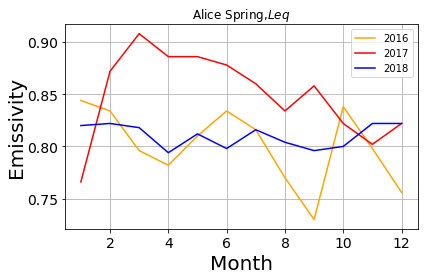

In [149]:
as_optlist[0]

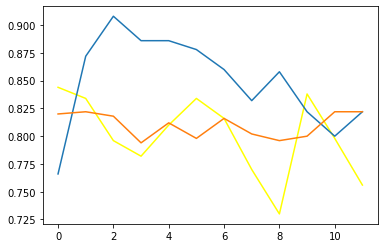

In [150]:
plt.plot(as_optlist[0],color='yellow')
plt.plot(as_optlist[1])
plt.plot(as_optlist[2])

### TUM leq bias

In [161]:
tum_optlist=opteps_leqlist(tumframe,2015,2018)
tum_leq_bias=opteps_leq_bias(Dfec_mod_tum,2015,2018,tum_optlist[0],tum_optlist[1],tum_optlist[2])
tum_leq_bias1=list(flatten(tum_leq_bias))
tum_leq_bias1=np.array(tum_leq_bias1)
tum_leq_bias2=tum_leq_bias1[~np.isnan(tum_leq_bias1)]
print(tum_leq_bias2)


[]


### Titree Leq bias

In [ ]:
titree_optlist=opteps_leqlist(titreeframe,2016,2018)
titree_leq_bias=opteps_leq_bias(Dfec_mod_titree,2016,2018,titree_optlist[0],titree_optlist[1],titree_optlist[2])
titree_leq_bias1=list(flatten(titree_leq_bias))
titree_leq_bias1=np.array(titree_leq_bias1)
titree_leq_bias2=titree_leq_bias1[~np.isnan(titree_leq_bias1)]
#print(titree_leq_bias2)


In [ ]:
sp_optlist=opteps_leqlist(spframe,2016,2018)
sp_leq_bias=opteps_leq_bias(Dfec_mod_sp,2016,2018,sp_optlist[0],sp_optlist[1],sp_optlist[2])
sp_leq_bias1=list(flatten(sp_leq_bias))
sp_leq_bias1=np.array(sp_leq_bias1)
sp_leq_bias2=sp_leq_bias1[~np.isnan(sp_leq_bias1)]
#print(sp_leq_bias2)

In [ ]:
lf_optlist=opteps_leqlist(lfframe,2016,2018)
lf_leq_bias=opteps_leq_bias(Dfec_mod_lf,2016,2018,lf_optlist[0],lf_optlist[1],lf_optlist[2])
lf_leq_bias1=list(flatten(lf_leq_bias))
lf_leq_bias1=np.array(lf_leq_bias1)
lf_leq_bias2=lf_leq_bias1[~np.isnan(lf_leq_bias1)]
print(lf_leq_bias2)

In [ ]:
## Replace ws with Ws_CSAT

ar_optlist=opteps_leqlist(arframe,2007,2009)
ar_leq_bias=opteps_leq_bias(Dfec_mod_ar,2007,2009,ar_optlist[0],ar_optlist[1],ar_optlist[2])
ar_leq_bias1=list(flatten(ar_leq_bias))
ar_leq_bias1=np.array(ar_leq_bias1)
ar_leq_bias2=ar_leq_bias1[~np.isnan(ar_leq_bias1)]
#print(ar_leq_bias2)

In [ ]:
ar_leq_bias1=list(flatten(ar_leq_bias))
ar_leq_bias1=np.array(ar_leq_bias1)
ar_leq_bias2=ar_leq_bias1[~np.isnan(ar_leq_bias1)]
#print(ar_leq_bias2)

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('temp bias boxplot')
plt.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)


box=plt.boxplot([lf_leq_bias2,tum_leq_bias2,
                as_leq_bias1,hs_leq_bias2,sp_leq_bias2,titree_leq_bias2,
                 ar_leq_bias2],1,patch_artist=True)
               
               


colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF','lightgreen']
for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)


ax1.set_axisbelow(True)
#ax1.set_title('Optimised emissivity obtained using complete longwave balance(leq)')
#ax1.set_xlabel('NAT Sites',fontsize=20)
ax1.set_ylabel(r'$T_{MODIS} -T_{Leq}(k)$', ha='center',fontsize=20)

numBoxes=7
medians=list(range(numBoxes))
for i in range(numBoxes):
    med = box['medians'][i]
    medianX = []
    medianY = []
    for j in range(2):
        medianX.append(med.get_xdata()[j])
        medianY.append(med.get_ydata()[j])
        plt.plot(medianX, medianY, 'k')
        medians[i] = medianY[0]
# Set the axes ranges and axes labels
ax1.set_xlim(0.5, numBoxes + 0.5)
top = 35
bottom = -25
ax1.set_ylim(bottom, top)
ax1.yaxis.set_tick_params(labelsize=15)
xtickNames = plt.setp(ax1, xticklabels=("Litchfield",
                                        "Tumbarumba","Alice Spring","Howard Spring",
                                       "Sturt Plains","Titree East","Adelaide River"))
plt.setp(xtickNames, rotation=45, fontsize=12, fontweight='bold')


pos = np.arange(numBoxes) + 1
upperLabels = [str(np.round(s, 2)) for s in medians]
weights = ['bold', 'semibold']
for tick, label in zip(range(numBoxes), ax1.get_xticklabels()):
    k = tick % 2
    ax1.text(pos[tick], top - (top*0.05), upperLabels[tick],
             horizontalalignment='center', size='x-large', weight=weights[k],
             color='k')


fname = 'opteps_modis_bias'
plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
plt.show()



        
        

# plot-scale & landscape-scale LST :

In [155]:
from itertools import chain

In [156]:
def opteps_leq_biasplot(site,df_all,yr_start,yr_end,list_optref1,list_optref2,list_optref3, eqdigits=3):
    eqdigits=3
    opt_Ts=[]
    Tmod=[]
    df_all= df_all.dropna(subset=['modistemp','Fld','Flu'])  
    list_months= list(range(1,13))

    for yr in range(yr_start,yr_end+1):
        
    
    
        for i in range(12):
            if yr == yr_start:
                epsilon1= list_optref1
            
            elif yr == yr_start + 1:
                epsilon1=list_optref2
           
            elif yr == yr_end:
                epsilon1=list_optref3
            
            if epsilon1[i]!= 1:
                df = df_all[(df_all.index.year == yr) & 
                            (df_all.index.month == list_months[i])]

                tf_T_s = theano_function([R_lin, R_lout], [eq_Ts_Rlout_Rlin.rhs.subs(epsilon, epsilon1[i]).
                                                              subs(Variable.__defaults__)], dims={R_lin:1, R_lout:1})

                list_T_s = tf_T_s(df.Fld,df.Flu)
                df = df.assign(T_s=list_T_s)
                opt_Ts.append(list_T_s.tolist())
                flat_optTs=list(chain.from_iterable(opt_Ts))
                Tmod.append(df.modistemp)
                flat_Tmod=list(chain.from_iterable(Tmod))
         
                 
    x=flat_Tmod
    print(len(x))
    y= flat_optTs
    print(len(y))
    x=np.array(x)
    y=np.array(y)
    x=x.reshape(-1,1)
    y=y.reshape(-1,1)
    reg=LinearRegression(fit_intercept=True).fit(x, y) ## 2d x
    m=float(reg.coef_.flatten())
    c=float(reg.intercept_)
    print(c)
    y_pred = m*x + c
    MSE= mean_squared_error(y,y_pred)
    RMSE=float(sqrt(MSE))
    N=len(y)
    r2=r2_score(y,y_pred)
    bias= np.mean((y_pred - x))

    legendtext = 'm={0}\n'r'R$^2$={1}''\nRMSE={2}\nN={3}''\nbias={4}'.format(str(np.round(m,decimals=eqdigits)),
                                                         str(np.round(r2,decimals=eqdigits)),
                                                         str(np.round(RMSE, decimals=eqdigits)),
                                                         str(np.round(N, decimals=eqdigits)),
                                                         str(np.round(bias, decimals=eqdigits))                                   )

    plt.plot(x,y,'.b',label='_none_')
    plt.plot(x,y_pred, "--" ,color='g',label=legendtext)#
    plt.plot([-9999,9999],[-9999,9999], color='k')# predicted
    plt.xlim(273, 330)
    plt.ylim(273, 330)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.text(325,320,'1:1',fontsize=14)
    plt.legend(loc="best", fontsize=12)
    plt.xlabel(r'$T_{MODIS}$', ha='center',fontsize=20)
    plt.ylabel(r'$T_{Leq}$', ha='center',fontsize=20)
    plottitle = '{0},'.format(str(site)) +' $\epsilon_{plot} $'
                                          
    fname = 'optleq{0}'.format(str(site))
    plt.title(plottitle, fontsize=20)
    plt.grid()
    plt.tight_layout()
    plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
    plt.show()
######################
                                                




In [ ]:
#opteps_leq_biasplot("Adelaide river",Dfec_mod_ar,2007,2009,ar_optlist[0],ar_optlist[1],ar_optlist[2])

224
224
38.817453383722125


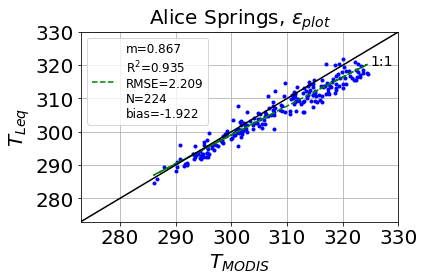

In [157]:
opteps_leq_biasplot("Alice Springs",Dfec_mod_as,2016,2018,as_optlist[0],as_optlist[1],as_optlist[2])

In [ ]:
opteps_leq_biasplot( "Litchfield",Dfec_mod_lf,2016,2018,lf_optlist[0],lf_optlist[1],lf_optlist[2])

In [ ]:
opteps_leq_biasplot("Sturt plains",Dfec_mod_sp,2016,2018,sp_optlist[0],sp_optlist[1],sp_optlist[2])

In [ ]:
opteps_leq_biasplot("Tumbarumba",Dfec_mod_tum,2015,2018,tum_optlist[0],tum_optlist[1],tum_optlist[2])

In [ ]:
opteps_leq_biasplot("Howards Springs",Dfec_mod_hs,2016,2018,Hs_optlist[0],Hs_optlist[1],Hs_optlist[2])

# plotting opt eps for all sites:

In [ ]:
aropt=np.array(ar_optlist)
aropt=list(flatten(aropt))
aropt=[np.nan if x==1 else x for x in aropt]
plt.plot(aropt)

In [ ]:

hsopt=np.array(Hs_optlist)
hsopt=list(flatten(hsopt))
hsopt=[np.nan if x==1 else x for x in hsopt]

#tumopt=tum_optlist.copy()
tumopt=np.array(tum_optlist)
tumopt=list(flatten(tumopt))
tumopt=[np.nan if x==1 else x for x in tumopt]

spopt=np.array(sp_optlist)
spopt=list(flatten(spopt))
spopt=[np.nan if x==1 else x for x in spopt]



asopt=np.array(as_optlist)
asopt=list(flatten(asopt))
asopt=[np.nan if x==1 else x for x in asopt]



aropt=np.array(ar_optlist)
aropt=list(flatten(aropt))
aropt=[np.nan if x==1 else x for x in aropt]


lfopt=np.array(lf_optlist)
lfopt=list(flatten(lfopt))
lfopt=[np.nan if x==1 else x for x in lfopt]




#titreeopt=titree_optlist.copy()
titreeopt=np.array(titree_optlist)
titreeopt=list(flatten(titreeopt))
titreeopt=[np.nan if x==1 else x for x in titreeopt]



aropt=np.array(ar_optlist)
aropt=list(flatten(aropt))
aropt=[np.nan if x==1 else x for x in aropt]

#colors = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','#0343DF'

mnths=np.arange(1,37)
fig=plt.figure(figsize=(14,10))
plt.plot(mnths,aropt , color='lightgreen',label='Adelaide River',linewidth=3)
plt.plot(mnths,titreeopt,color='#0343DF', label='TiTree East',linewidth=3)
plt.plot(mnths,lfopt,color='#E69F00', label='Litchfield',linewidth=3)
plt.plot(mnths,spopt,color='#D55E00' , label='Sturt Plains',linewidth=3)
plt.plot(mnths,asopt,color='#F0E442', label='Alice Spring',linewidth=3)
plt.plot(mnths,hsopt,color='#009E73',label='Howard Spring',linewidth=3)
plt.plot(mnths,tumopt, color= '#56B4E9',label='Tumbarumba',linewidth=3)

plt.xticks(np.arange(1,37),fontsize=12)
plt.yticks(fontsize=16)
plt.xlabel('Months',fontsize=16)
plt.ylabel(r'$\epsilon_{leq}$',fontsize=24,fontweight='bold')
plt.legend()
plt.grid()
fname = 'opteps_leqsite'
plt.savefig(plt_path+fname+'.png',facecolor='w', edgecolor='w', orientation='portrait')
plt.show()


## Using Short equation :